# Наложение очков на лицо с размытием фона

В этом ноутбуке мы демонстрируем:

1. Обнаружение лица и глаз с помощью OpenCV.
2. Создание маски для лица и размытие фона, оставляя глаза в фокусе.
3. Наложение очков с прозрачными линзами на лицо.
4. Контур очков почти непрозрачный, а линзы полупрозрачные.
5. Визуализацию результата.


## Импорт библиотек

Импортируем библиотеки для обработки изображений, загрузки файлов и визуализации результата.


In [20]:
import cv2
import gdown
import numpy as np
from matplotlib import pyplot as plt

## Настройки параметров

Задаем ключевые параметры обработки: порог для выделения фона очков, размеры морфологических операций, прозрачность линз и степень размытия лица.


In [21]:
white_thresh = 245   # порог, выше которого пиксель считаем "белым фоном"
morph_kernel_size = 3  # для очистки маски очков
lens_opacity = 0.18    # прозрачность линз очков
blur_ksize = (51, 51)  # размер ядра для размытия лица

## Загрузка изображений

Загружаем изображение актера и очков. Если загрузка не удалась — скрипт завершает работу.


In [22]:
gdown.download('https://video.kinoafisha.info/news/8341900_176104986687.jpg', 'actor.jpg', quiet=True)
gdown.download('https://www.pngmart.com/files/20/Picart-Sunglasses-PNG-Picture.png', 'glasses_white_bg.png', quiet=True)

img = cv2.imread('actor.jpg')
glasses = cv2.imread('glasses_white_bg.png', cv2.IMREAD_UNCHANGED)

if img is None or glasses is None:
    raise RuntimeError("Не удалось загрузить одно из изображений (actor или glasses).")

## Классификаторы лица и глаз

Используем встроенные каскадные классификаторы OpenCV для обнаружения лиц и глаз на изображении.


In [23]:
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
classifier_eyes = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

## Функции для обработки изображений

- `make_alpha_from_rgb` — создаёт маску для очков из белого фона.  
- `blur_face` — размывает лицо, исключая область глаз.


In [24]:
def make_alpha_from_rgb(img_rgb, white_thresh=245, morph_k=3):
    """Создаёт альфа-канал для изображения очков на белом фоне"""
    bgr = img_rgb[:, :, :3].copy()
    white_mask = np.all(bgr >= white_thresh, axis=2).astype(np.uint8)
    alpha = (1 - white_mask) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_k, morph_k))
    alpha = cv2.morphologyEx(alpha, cv2.MORPH_OPEN, kernel)
    alpha = cv2.morphologyEx(alpha, cv2.MORPH_CLOSE, kernel)
    return bgr, alpha.astype(np.uint8)

def blur_face(img, mask, exclude_mask=None, ksize=(51,51)):
    """Размывает лицо за маской, исключая глаза"""
    blurred = cv2.GaussianBlur(img, ksize, 0)
    mask_use = mask.copy()
    if exclude_mask is not None:
        exclude = (exclude_mask > 0).astype(np.uint8) * 255
        mask_use = cv2.bitwise_and(mask_use, cv2.bitwise_not(exclude))
    mask_3ch = cv2.cvtColor(mask_use, cv2.COLOR_GRAY2BGR)
    return np.where(mask_3ch == 255, blurred, img)

## Обнаружение лиц и глаз, размывание фона

1. Находим лица и глаза.  
2. Создаём маску лица и маску глаз.  
3. Размываем фон лица, исключая глаза.  
4. Рисуем овал вокруг лица для визуализации.


In [25]:
img2 = img.copy()
faces = classifier_face.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5, minSize=(80, 80))

for (x, y, w, h) in faces:
    mask_full = np.zeros(img.shape[:2], dtype=np.uint8)
    center = (x + w // 2, y + h // 2)
    axes = (int(w * 0.6), int(h * 0.75))
    cv2.ellipse(mask_full, center, axes, 0, 0, 360, 255, -1)

    face_gray = cv2.cvtColor(img[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)
    eyes = classifier_eyes.detectMultiScale(face_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    eyes_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    if len(eyes) >= 2:
        eyes = sorted(eyes, key=lambda e: e[0])
        ex1, ey1, ew1, eh1 = eyes[0]
        ex2, ey2, ew2, eh2 = eyes[1]
        g_ex1, g_ey1 = x + ex1, y + ey1
        g_ex2, g_ey2 = x + ex2, y + ey2
        cv2.ellipse(eyes_mask, (g_ex1 + ew1//2, g_ey1 + eh1//2), (int(ew1*0.7), int(eh1*0.8)), 0, 0, 360, 255, -1)
        cv2.ellipse(eyes_mask, (g_ex2 + ew2//2, g_ey2 + eh2//2), (int(ew2*0.7), int(eh2*0.8)), 0, 0, 360, 255, -1)

    img2 = blur_face(img2, mask_full, exclude_mask=eyes_mask, ksize=blur_ksize)
    cv2.ellipse(img2, center, axes, 0, 0, 360, (0, 255, 0), 2)

## Наложение очков

- Выделяем альфа-канал очков или создаём его из белого фона.  
- Масштабируем очки под глаза.  
- Разделяем линзы и контур: линзы полупрозрачные, контур почти непрозрачный.  
- Накладываем очки на изображение.


In [26]:
if glasses.shape[2] == 4:
    g_bgr = glasses[:, :, :3].copy()
    g_alpha = glasses[:, :, 3].copy()
else:
    g_bgr, g_alpha = make_alpha_from_rgb(glasses, white_thresh=white_thresh, morph_k=morph_kernel_size)

if len(eyes) >= 2:
    eye_center_y = y + (ey1 + ey2) // 2
    eye_left_x = x + ex1
    eye_right_x = x + ex2 + ew2
    eye_width = eye_right_x - eye_left_x
    eye_height = max(eh1, eh2)

    gw, gh = max(20, int(eye_width * 1.5)), max(10, int(eye_height * 2.0))
    gx = int((eye_left_x + eye_right_x) / 2 - gw / 2)
    gy = int(eye_center_y - gh / 3)

    glasses_bgr_resized = cv2.resize(g_bgr, (gw, gh), interpolation=cv2.INTER_AREA).astype(np.float32)
    glasses_alpha_resized = cv2.resize(g_alpha, (gw, gh), interpolation=cv2.INTER_AREA).astype(np.float32) / 255.0

    alpha_bin = (glasses_alpha_resized > 0.01).astype(np.uint8) * 255
    kx = max(3, gw // 12)
    ky = max(3, gh // 12)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kx, ky))
    alpha_bin_clean = cv2.morphologyEx(alpha_bin, cv2.MORPH_CLOSE, kernel, iterations=1)
    eroded = cv2.erode(alpha_bin_clean, kernel, iterations=1)

    eroded_bool = (eroded > 0)
    edge_bool = (alpha_bin_clean > 0) & (~eroded_bool)

    contour_alpha = glasses_alpha_resized.copy()
    contour_alpha[eroded_bool] = glasses_alpha_resized[eroded_bool] * lens_opacity
    contour_alpha[edge_bool] = np.maximum(glasses_alpha_resized[edge_bool], 0.95)
    alpha_eff = contour_alpha

    y1, y2 = max(0, gy), min(img2.shape[0], gy + gh)
    x1, x2 = max(0, gx), min(img2.shape[1], gx + gw)
    sy1, sy2 = y1 - gy, y2 - gy
    sx1, sx2 = x1 - gx, x2 - gx

    if y1 < y2 and x1 < x2:
        roi = img2[y1:y2, x1:x2].astype(np.float32)
        g_part = glasses_bgr_resized[sy1:sy2, sx1:sx2]
        a_part = alpha_eff[sy1:sy2, sx1:sx2][:, :, np.newaxis]

        blended = (1.0 - a_part) * roi + a_part * g_part
        img2[y1:y2, x1:x2] = np.clip(blended, 0, 255).astype(np.uint8)

## Отображение результата

Отображаем финальное изображение с размытым фоном и наложенными очками.


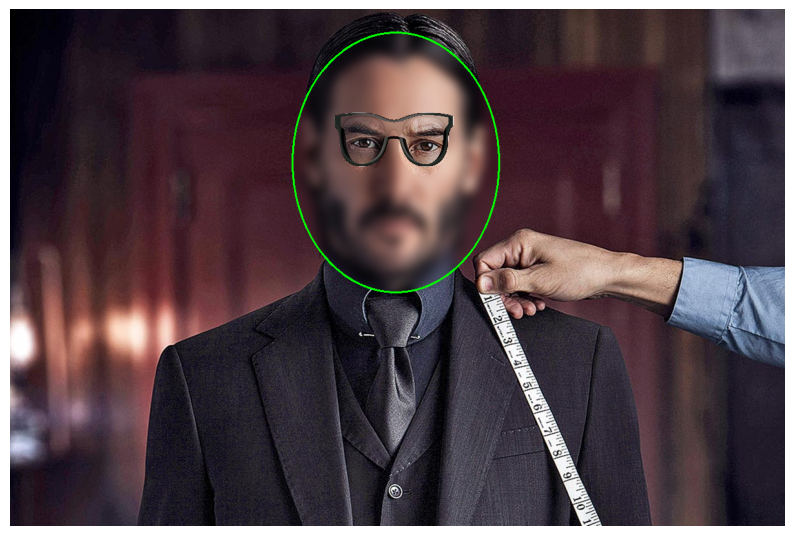

In [27]:
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Вывод

- Код корректно накладывает очки на лицо с прозрачными линзами.  
- Контур очков почти непрозрачный, линзы прозрачные.  
- Лицо размыто, глаза остаются в фокусе.  
